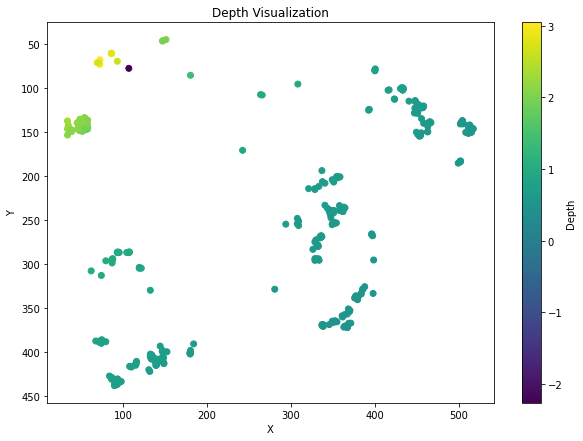

True

In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 读取图像
image_path1 = '/home/jiaoao/SLAMHW/image/0000001-000000000000.jpg'
image_path2 = '/home/jiaoao/SLAMHW/image/0000002-000000033516.jpg'
image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

# 初始化ORB检测器
orb = cv2.ORB_create()

# 检测特征点和描述符
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# 使用BFMatcher进行特征点匹配
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

# 提取匹配的关键点
points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# 读取相机内参
intrinsics = np.array([[570.342224, 0, 320.000000],
                       [0, 570.342224, 240.000000],
                       [0, 0, 1]])

# 计算本质矩阵
E, mask = cv2.findEssentialMat(points1, points2, intrinsics, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# 从本质矩阵中恢复相机位姿
_, R, t, mask = cv2.recoverPose(E, points1, points2, intrinsics)

# 计算深度
points1_homogeneous = cv2.convertPointsToHomogeneous(points1)[:, 0, :2].T
points2_homogeneous = cv2.convertPointsToHomogeneous(points2)[:, 0, :2].T
points1_3d = cv2.triangulatePoints(np.eye(3, 4), np.hstack((R, t)), points1_homogeneous, points2_homogeneous)
points1_3d /= points1_3d[3]

# 创建输出文件夹
output_folder = 'FeaturePoints'
os.makedirs(output_folder, exist_ok=True)

# 保存深度信息到文件
depth_output_path = os.path.join(output_folder, 'depth_info.txt')
np.savetxt(depth_output_path, points1_3d.T, fmt='%f')

# 可视化深度信息
depths = points1_3d[2]
plt.figure(figsize=(10, 7))
plt.scatter(points1[:, 0], points1[:, 1], c=depths, cmap='viridis')
plt.colorbar(label='Depth')
plt.gca().invert_yaxis()
plt.title('Depth Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig(os.path.join(output_folder, 'depth_visualization.png'))
plt.show()


In [4]:
import cv2
import numpy as np
import os

# 读取图像
image_path1 = '/home/jiaoao/SLAMHW/image/0000001-000000000000.jpg'
image_path2 = '/home/jiaoao/SLAMHW/image/0000002-000000033516.jpg'
image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

# 检查图像是否读取成功
if image1 is None:
    raise ValueError(f"Failed to load image: {image_path1}")
if image2 is None:
    raise ValueError(f"Failed to load image: {image_path2}")

# 读取深度图像
depth_path1 = '/home/jiaoao/SLAMHW/depth/0000001-000000000000.png'
depth_path2 = '/home/jiaoao/SLAMHW/depth/0000002-000000033464.png'
depth1 = cv2.imread(depth_path1, cv2.IMREAD_UNCHANGED)
depth2 = cv2.imread(depth_path2, cv2.IMREAD_UNCHANGED)

# 检查深度图像是否读取成功
if depth1 is None:
    raise ValueError(f"Failed to load depth image: {depth_path1}")
if depth2 is None:
    raise ValueError(f"Failed to load depth image: {depth_path2}")

# 检查深度图像是否为16位
if depth1.dtype != np.uint16 or depth2.dtype != np.uint16:
    raise ValueError("Depth images are not 16-bit PNG files.")

# 将深度图像的像素值右移3位，恢复原始深度值
depth1 = depth1 >> 3
depth2 = depth2 >> 3

# 将深度值从毫米转换为米
depth1 = depth1 * 0.001
depth2 = depth2 * 0.001

# 计算统计特征
def calculate_statistics(depth):
    return {
        'mean': np.mean(depth),
        'median': np.median(depth),
        'std_dev': np.std(depth),
        'min': np.min(depth),
        'max': np.max(depth)
    }

stats_depth1 = calculate_statistics(depth1)
stats_depth2 = calculate_statistics(depth2)

print("Statistics for depth1:")
for key, value in stats_depth1.items():
    print(f"{key}: {value}")

print("\nStatistics for depth2:")
for key, value in stats_depth2.items():
    print(f"{key}: {value}")

# 保存处理后的图像和深度图像
output_dir = '/home/jiaoao/SLAMHW/output'

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存原始图像
cv2.imwrite(os.path.join(output_dir, 'image1.jpg'), image1)
cv2.imwrite(os.path.join(output_dir, 'image2.jpg'), image2)

# 保存深度图像（将深度图像转换为8位以便保存和查看）
depth1_vis = (depth1 / np.max(depth1) * 255).astype(np.uint8)
depth2_vis = (depth2 / np.max(depth2) * 255).astype(np.uint8)
cv2.imwrite(os.path.join(output_dir, 'depth1.png'), depth1_vis)
cv2.imwrite(os.path.join(output_dir, 'depth2.png'), depth2_vis)

# 打印保存路径
print(f"Images and depth maps saved to {output_dir}")


Statistics for depth1:
mean: 1.1786363899739585
median: 1.077
std_dev: 0.5768283608228689
min: 0.0
max: 2.541

Statistics for depth2:
mean: 1.1781610774739586
median: 1.073
std_dev: 0.5752932597226414
min: 0.0
max: 2.503
Images and depth maps saved to /home/jiaoao/SLAMHW/output


In [6]:

import cv2
import numpy as np
import os
fx,fy,cx,cy = 570.342224, 570.342224, 320.000000, 240.000000

def calculate_statistics(depth):
    return {
        'mean': np.mean(depth),
        'median': np.median(depth),
        'std_dev': np.std(depth),
        'min': np.min(depth),
        'max': np.max(depth)
    }

def calculate_mae(depth1, depth2):
    valid_mask = (depth1 > 0) & (depth2 > 0)  # 只计算有效深度值的误差
    return np.mean(np.abs(depth1[valid_mask] - depth2[valid_mask]))

# 读取图像
image_path1 = '/home/jiaoao/SLAMHW/image/0000001-000000000000.jpg'
image_path2 = '/home/jiaoao/SLAMHW/image/0000002-000000033516.jpg'
image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)  # 应该如何load呢
image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
# 读取深度图像
depth_path1 = '/home/jiaoao/SLAMHW/depth/0000001-000000000000.png'
depth_path2 = '/home/jiaoao/SLAMHW/depth/0000002-000000033464.png'
depth1 = cv2.imread(depth_path1, cv2.IMREAD_UNCHANGED)
depth2 = cv2.imread(depth_path2, cv2.IMREAD_UNCHANGED)

# 检查深度图像是否读取成功
if depth1 is None:
    raise ValueError(f"Failed to load depth image: {depth_path1}")
if depth2 is None:
    raise ValueError(f"Failed to load depth image: {depth_path2}")

# 检查深度图像是否为16位
if depth1.dtype != np.uint16 or depth2.dtype != np.uint16:
    raise ValueError("Depth images are not 16-bit PNG files.")

# 将深度图像的像素值右移3位，恢复原始深度值
depth1 = depth1 >> 3
depth2 = depth2 >> 3

# 将深度值从毫米转换为米
depth1 = depth1 * 0.001
depth2 = depth2 * 0.001
# 检查图像是否读取成功
if image1 is None:
    raise ValueError(f"Failed to load image: {image_path1}")
if image2 is None:
    raise ValueError(f"Failed to load image: {image_path2}")

# 使用 ORB 特征检测和描述子
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(image1, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# 使用 BFMatcher 进行特征匹配
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# 提取匹配点
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

# 计算基础矩阵
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# 相机内参矩阵（假设已知）
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])  

# 计算本质矩阵
E = K.T @ F @ K

# 从本质矩阵中恢复相机姿态
points, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

# 输出相机位姿
print("Rotation Matrix R:")
print(R)
print("Translation Vector t:")
print(t)

# 使用三角化方法估计深度
projMatr1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
projMatr2 = K @ np.hstack((R, t))

pts_4d_hom = cv2.triangulatePoints(projMatr1, projMatr2, pts1.T, pts2.T)
pts_4d = pts_4d_hom / pts_4d_hom[3] #  归一化
triangulated_depths = pts_4d[2]

# 保存三角化后的深度信息
output_dir = '/home/jiaoao/SLAMHW/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

triangulated_depths_file = os.path.join(output_dir, 'triangulated_depths.txt')
np.savetxt(triangulated_depths_file, triangulated_depths)
print(f"Triangulated depths saved to {triangulated_depths_file}")

# 提取对应的原始深度值进行对比
def extract_depths_at_keypoints(depth_img, keypoints):
    depths = []
    for pt in keypoints:
        x, y = int(pt[0]), int(pt[1])
        if 0 <= x < depth_img.shape[1] and 0 <= y < depth_img.shape[0]:
            depths.append(depth_img[y, x])
        else:
            depths.append(0)
    return np.array(depths)

original_depths1 = extract_depths_at_keypoints(depth1, pts1)
original_depths2 = extract_depths_at_keypoints(depth2, pts2)

# 计算 MAE
mae1 = calculate_mae(triangulated_depths, original_depths1)
mae2 = calculate_mae(triangulated_depths, original_depths2)

print(f"MAE for image1 depth comparison: {mae1}")
print(f"MAE for image2 depth comparison: {mae2}")



Rotation Matrix R:
[[ 9.99990867e-01  4.27376609e-03 -3.50000644e-05]
 [-4.27384282e-03  9.99987469e-01 -2.60703560e-03]
 [ 2.38577654e-05  2.60716138e-03  9.99996601e-01]]
Translation Vector t:
[[-0.16672418]
 [ 0.19679237]
 [ 0.96616552]]
Triangulated depths saved to /home/jiaoao/SLAMHW/output/triangulated_depths.txt
MAE for image1 depth comparison: 381.54510165118535
MAE for image2 depth comparison: 381.5455446042055


In [20]:
original_depths1.mean()

1.2409285714285716

-342.02762

最小距离：1.000000
最大距离：83.000000
匹配数：324


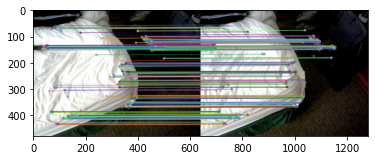

In [1]:
import cv2 as cv  ## opencv-python==3.4.8.29
import numpy as np
from  matplotlib import pyplot as plt
 
# 读取图片
im1 = cv.imread('/home/jiaoao/SLAMHW/image/0000001-000000000000.jpg')
im2 = cv.imread('/home/jiaoao/SLAMHW/image/0000002-000000033516.jpg')
 
# ORB特征提取
orb = cv.ORB_create()
kp1 = orb.detect(im1)  
kp2 = orb.detect(im2)
kp1, des1 = orb.compute(im1, kp1) # 求特征
kp2, des2 = orb.compute(im2, kp2) # 求特征
bf = cv.BFMatcher(cv.NORM_HAMMING)# 初始化Matcher
matches = bf.match(des1, des2)    # 配准
# 进行初步筛选
min_distance = 10000
max_distance = 0
for x in matches:
    if x.distance < min_distance: min_distance = x.distance
    if x.distance > max_distance: max_distance = x.distance
print('最小距离：%f' % min_distance)
print('最大距离：%f' % max_distance)
good_match = []
for x in matches:
    if x.distance <= max(2 * min_distance, 30):
        good_match.append(x)
print('匹配数：%d' % len(good_match))
outimage = cv.drawMatches(im1, kp1, im2, kp2, good_match, outImg=None)
plt.imshow(outimage[:,:,::-1])
plt.show()

In [2]:
# 提取配准点
points1 = []
points2 = []
for i in good_match:
    points1.append(list(kp1[i.queryIdx].pt));
    points2.append(list(kp2[i.trainIdx].pt));
points1 = np.array(points1)
points2 = np.array(points2)
#em,mask = cv.findEssentialMat(points1, points2, K, cv.RANSAC, 0.999, 1.0,np.array([])) #opencv4
#em,mask = cv.findEssentialMat(points1, points2, 521, (325.1,249.7), cv.RANSAC, 0.999, 1.0,np.array([])) #opencv3
# 相机内参
K = np.array([[570.342224, 0, 320.0], 
              [0, 570.342224, 240.0], 
              [0, 0, 1]])

# 计算本质矩阵
em, mask = cv.findEssentialMat(points1, points2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)

# 求解位姿
num, R, t, mask = cv.recoverPose(em, points1, points2, K)

print(f'旋转矩阵：\n{R}')
print(f'平移向量：\n{t}')
# print(em)
# print(mask)
 

旋转矩阵：
[[ 0.46654256 -0.73793073 -0.4876436 ]
 [-0.7354087  -0.62994586  0.2496843 ]
 [-0.49143878  0.242129   -0.83657724]]
平移向量：
[[ 0.85724112]
 [-0.43067368]
 [-0.2822372 ]]


In [3]:
projMatr1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])    # 第一个相机参数
projMatr2 = np.concatenate((R, t), axis=1)               # 第二个相机参数
projMatr1 = np.matmul(K, projMatr1) # 相机内参 相机外参
projMatr2 = np.matmul(K, projMatr2) #
points4D = cv.triangulatePoints(projMatr1, projMatr2, points1.T, points2.T)
points4D /= points4D[3]       # 归一化
points4D = points4D.T[:,0:3]  # 取坐标点
print(points4D[0:5])

[[-0.23381097  0.21495242  0.72900539]
 [-0.19872511  0.23036898  0.81007618]
 [-0.25732632  0.22346256  0.64665399]
 [-0.28301929  0.16907903  0.65407161]
 [-0.28133905  0.16886537  0.6549911 ]]


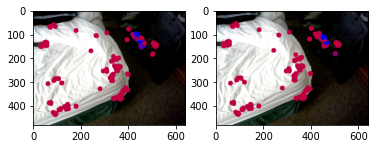

In [4]:
def get_color(depth):
    up_th = 50
    low_th = 10
    th_range = up_th - low_th;
    if (depth > up_th):
        depth = up_th;
    if (depth < low_th):
        depth = low_th;
    return (255 * depth / th_range, 0, 255 * (1 - depth / th_range));
 
## 可视化
for i in range(points1.shape[0]):
    # 第一幅图
    im1 = cv.circle(im1, (points1[i][0].astype(int),points1[i][1].astype(int)), 10,get_color(points4D[i,2]), -1)
    # 第二幅图
    tmp_point = np.dot(R,points4D[i,:].reshape(3,1)) + t
    tmp_point = tmp_point.reshape(-1)
    im2 = cv.circle(im2, (points2[i][0].astype(int),points2[i][1].astype(int)), 10,get_color(tmp_point[2]), -1)
plt.subplot(121)
plt.imshow(im1[:,:,::-1])
plt.subplot(122)
plt.imshow(im2[:,:,::-1])
plt.show()

In [5]:
points4D[:,2].mean()

-0.4822355741374268

最小距离：1.0
最大距离：83.0
匹配数：324


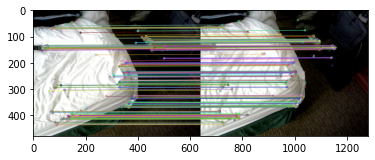

旋转矩阵：
[[ 0.46654256 -0.73793073 -0.4876436 ]
 [-0.7354087  -0.62994586  0.2496843 ]
 [-0.49143878  0.242129   -0.83657724]]
平移向量：
[[ 0.85724112]
 [-0.43067368]
 [-0.2822372 ]]


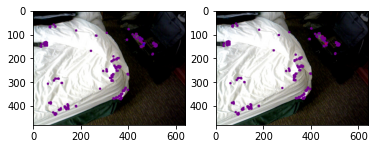

In [134]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# 读取图片
im1 = cv.imread('/home/jiaoao/SLAMHW/image/0000001-000000000000.jpg')
im2 = cv.imread('/home/jiaoao/SLAMHW/image/0000002-000000033516.jpg')

# ORB特征提取
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(im1, None)
kp2, des2 = orb.detectAndCompute(im2, None)

# 初始化BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING)

# 特征点匹配
matches = bf.match(des1, des2)

# 筛选匹配点
min_distance = min(matches, key=lambda x: x.distance).distance
max_distance = max(matches, key=lambda x: x.distance).distance

print(f'最小距离：{min_distance}')
print(f'最大距离：{max_distance}')

# 筛选优秀匹配
good_match = [m for m in matches if m.distance <= max(2 * min_distance, 30)]
print(f'匹配数：{len(good_match)}')

# 绘制匹配结果
outimage = cv.drawMatches(im1, kp1, im2, kp2, good_match, None)
plt.imshow(outimage[:,:,::-1])
plt.show()

# 提取配准点
points1 = np.array([kp1[m.queryIdx].pt for m in good_match])
points2 = np.array([kp2[m.trainIdx].pt for m in good_match])

# 相机内参
K = np.array([[570.342224, 0, 320.0], 
              [0, 570.342224, 240.0], 
              [0, 0, 1]])

# 计算本质矩阵
em, mask = cv.findEssentialMat(points1, points2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)

# 求解位姿
num, R, t, mask = cv.recoverPose(em, points1, points2, K)

print(f'旋转矩阵：\n{R}')
print(f'平移向量：\n{t}')

# 计算投影矩阵
projMatr1 = np.hstack((np.eye(3), np.zeros((3, 1))))
projMatr2 = np.hstack((R, t))

projMatr1 = K @ projMatr1
projMatr2 = K @ projMatr2

# 三角化求解3D点
points4D = cv.triangulatePoints(projMatr1, projMatr2, points1.T, points2.T)
points4D /= points4D[3]
points4D = points4D[:3].T

# 获取深度范围
depths = points4D[:, 2]
min_depth = np.min(depths)
max_depth = np.max(depths)

# 可视化函数
def get_color(depth, min_depth, max_depth):
    normalized_depth = (depth - min_depth) / (max_depth - min_depth)
    return (255 * (1 - normalized_depth), 0, 255 * normalized_depth)

# 可视化
for i in range(len(points1)):
    color = get_color(points4D[i, 2], min_depth, max_depth)
    im1 = cv.circle(im1, tuple(points1[i].astype(int)), 5, color, -1)
    tmp_point = (R @ points4D[i].reshape(3, 1) + t).flatten()
    color = get_color(tmp_point[2], min_depth, max_depth)
    im2 = cv.circle(im2, tuple(points2[i].astype(int)), 5, color, -1)

plt.subplot(121)
plt.imshow(im1[:,:,::-1])
plt.subplot(122)
plt.imshow(im2[:,:,::-1])
plt.show()


In [136]:
points4D[:,2].mean()

-0.4822355741374268

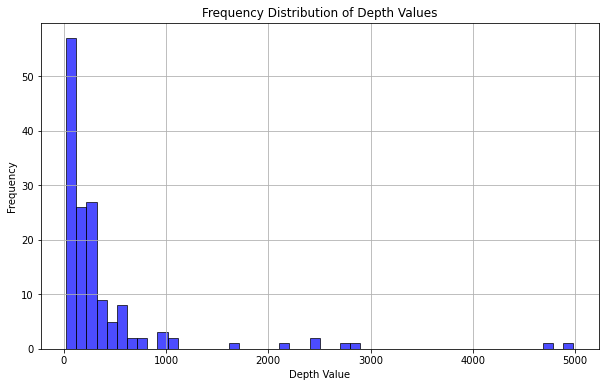

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 读取深度值数据文件
file_path = '/home/jiaoao/SLAMHW/output/triangulated_depths.txt'

# 读取文件中的数据
with open(file_path, 'r') as file:
    depth_values = [float(line.strip()) for line in file]

# 转换为numpy数组
depth_values = np.array(depth_values)

# 过滤掉负值（如果需要）
depth_values = depth_values[depth_values >= 0]

# 绘制频率分布图（直方图）
plt.figure(figsize=(10, 6))
plt.hist(depth_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Frequency Distribution of Depth Values')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()